In [7]:
import os

cwd = Path(os.getcwd()).parent
input_dir = Path(cwd, "data", "raw")
output_dir = Path(cwd, "data", "processed")
output_dir.mkdir(exist_ok=True)


In [8]:
from pathlib import Path
import numpy as np
from scipy.signal import stft

# ----------------------------
# STFT conversion
# ----------------------------
def signal_to_spectrogram(
    signal: np.ndarray,
    fs: int,
    n_fft: int = 256,
    hop_length: int = 128
) -> np.ndarray:
    _, _, Zxx = stft(
        signal,
        fs=fs,
        window="hann",
        nperseg=n_fft,
        noverlap=n_fft - hop_length,
        boundary=None
    )
    return np.log1p(np.abs(Zxx))


# ----------------------------
# Directory processing
# ----------------------------
FS = 1000
for class_dir in input_dir.iterdir():
    if not class_dir.is_dir():
        continue

    out_class_dir = output_dir / class_dir.name
    out_class_dir.mkdir(exist_ok=True)

    for npy_file in class_dir.glob("*.npy"):
        signal = np.load(npy_file)

        if signal.ndim != 1:
            raise ValueError(f"{npy_file} is not 1D")

        spec = signal_to_spectrogram(signal, fs=FS)

        np.save(out_class_dir / npy_file.name, spec)


In [13]:
import matplotlib.pyplot as plt

def plot_spectrogram_0_100hz(
    signal: np.ndarray,
    fs: int,
    n_fft: int = 1024,
    hop_length: int = 256,
    title: str | None = None
) -> None:
    """
    Display log-magnitude spectrogram limited to 0–100 Hz.
    """

    if signal.ndim != 1:
        raise ValueError("Signal must be 1D")

    f, t, Zxx = stft(
        signal,
        fs=fs,
        window="hann",
        nperseg=n_fft,
        noverlap=n_fft - hop_length,
        boundary=None
    )

    spec = np.log1p(np.abs(Zxx))

    # ---- frequency cropping ----
    freq_mask = f <= 100
    f = f[freq_mask]
    spec = spec[freq_mask, :]

    plt.figure(figsize=(8, 4))
    plt.pcolormesh(t, f, spec, shading="gouraud")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Log magnitude")

    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()

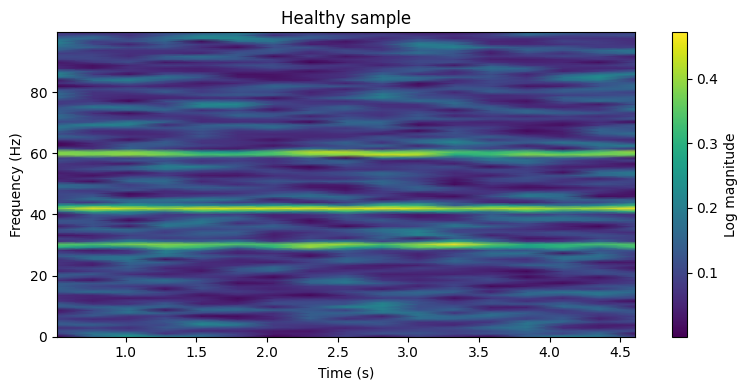

In [14]:
signal = np.load(Path(input_dir, 'healthy', 'healthy_0000.npy'))
plot_spectrogram_0_100hz(signal, fs=1000, title="Healthy sample")

In [20]:
### Final processing
input_dir = Path(cwd, "data", "raw")
output_dir = Path(cwd, "data", "final")
output_dir.mkdir(exist_ok=True)

In [21]:
def save_spectrogram_png(
    signal: np.ndarray,
    out_path: Path,
    fs: int,
    n_fft: int = 1024,
    hop_length: int = 256,
    f_max: int = 100
) -> None:
    """
    Save a 0–f_max Hz log-magnitude spectrogram as a PNG file.
    """

    f, t, Zxx = stft(
        signal,
        fs=fs,
        window="hann",
        nperseg=n_fft,
        noverlap=n_fft - hop_length,
        boundary=None
    )

    spec = np.log1p(np.abs(Zxx))

    # Crop frequency axis
    freq_mask = f <= f_max
    f = f[freq_mask]
    spec = spec[freq_mask, :]

    plt.figure(figsize=(4, 4))
    plt.pcolormesh(t, f, spec, shading="gouraud")
    plt.axis("off")          # CNNs do not care about axes
    plt.tight_layout(pad=0)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=150, bbox_inches="tight", pad_inches=0)
    plt.close()

In [22]:
for class_dir in input_dir.iterdir():
    if not class_dir.is_dir():
        continue

    for npy_file in class_dir.glob("*.npy"):
        signal = np.load(npy_file)

        if signal.ndim != 1:
            raise ValueError(f"{npy_file} is not 1D")

        out_file = (
            output_dir
            / class_dir.name
            / npy_file.with_suffix(".png").name
        )

        save_spectrogram_png(
            signal=signal,
            out_path=out_file,
            fs=FS
        )